In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import pennylane as qml
import numpy as np
import matplotlib.pyplot as plt

### Model Definitions

In [2]:
class Discriminator(nn.Module):
    def __init__(self, input_size, hid_size) -> None:
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, hid_size),
            nn.ReLU(),
            nn.Linear(hid_size, hid_size),
            nn.ReLU(),
            nn.Linear(hid_size, 1),
            nn.Sigmoid(),
        )
    def forward(self, x):
        return self.layers(x)
    
class Generator(nn.Module):
    def __init__(self, input_size, hid_size, out_size) -> None:
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, hid_size),
            nn.ReLU(),
            nn.Linear(hid_size, hid_size),
            nn.ReLU(),
            nn.Linear(hid_size, out_size),
        )
    def forward(self, x):
        return self.layers(x)

### Dataset Generation

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


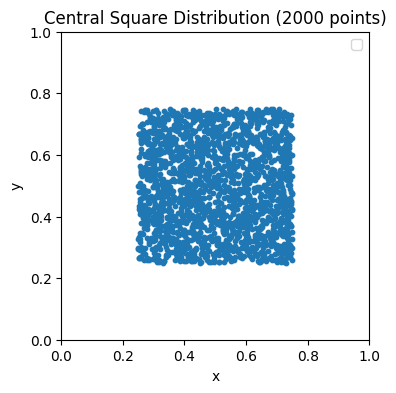

In [3]:
N_points = 2000 # From paper

np.random.seed(0)

x = np.random.uniform(low=0.25, high=0.75, size=N_points)
y = np.random.uniform(low=0.25, high=0.75, size=N_points)

# Plot the data
plt.figure(figsize=(4, 4))
plt.scatter(x, y, alpha=1, s=10)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel('x')
plt.ylabel('y')
plt.title("Central Square Distribution (2000 points)")
plt.gca().set_aspect('equal', adjustable='box')  # Make the plot square
plt.legend()
plt.show()

In [4]:
from torch.utils.data import Dataset, DataLoader

class XYDistribution(Dataset):
    def __init__(self, x, y):
        self.x = torch.tensor(x, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        return torch.stack((self.x[idx], self.y[idx]))

### Training

In [13]:
noise_size = 4

net_D = Discriminator(2, 16)
net_G = Generator(noise_size, 16, 2)

batch_size = 40

dataset = XYDistribution(x, y)
dataloader = DataLoader(dataset, batch_size=batch_size)

criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = 0.5 + torch.randn(batch_size, noise_size)*2

real_label = 1.
fake_label = 0.
epochs = 1000
lr = 1e-4

optimizerD = optim.Adam(net_D.parameters(), lr=lr)
optimizerG = optim.Adam(net_G.parameters(), lr=lr)
    

In [14]:
d_error = []
g_error = []
fk_prog = []

for _ in range(epochs):
    for batch in dataloader:
        # First Update Discriminator with batch of Real Data
        net_D.zero_grad()
        labels_real = torch.ones((batch_size, 1))
        outputs = net_D(batch)
        loss_d_real = criterion(outputs, labels_real)
        loss_d_real.backward()

        # Update with "Fake" Generator Data
        rand_inps = 0.5 + torch.randn((batch_size, noise_size)) * 2
        gen_outp = net_G(rand_inps)
        labels_fk = torch.zeros((batch_size, 1))
        outputs = net_D(gen_outp)
        loss_d_fake = criterion(outputs, labels_fk)
        loss_d_fake.backward()

        loss_d = loss_d_fake + loss_d_real
        optimizerD.step()

        # Update the Generator Network to Maximize Discriminator Error
        net_G.zero_grad()
        # Do D forward pass again on newly updated network
        labels_real_gen = torch.ones((batch_size, 1))
        gen_outp_2 = net_G(rand_inps)
        outputs = net_D(gen_outp_2)
        loss_g = criterion(outputs, labels_real_gen)
        loss_g.backward()

        optimizerG.step()

        d_error.append(loss_d.item())
        g_error.append(loss_g.item())
    print("Discriminator Loss: ", loss_d.item(), "Generator Loss", loss_g.item())

    with torch.no_grad():
        fake = net_G(fixed_noise)
        # print("GENERATOR PROGRESS: ", fake)
        fk_prog.append(fake)

Discriminator Loss:  1.3827426433563232 Generator Loss 0.7054992914199829
Discriminator Loss:  1.3826429843902588 Generator Loss 0.7008155584335327
Discriminator Loss:  1.3842097520828247 Generator Loss 0.6946290731430054
Discriminator Loss:  1.386487364768982 Generator Loss 0.6893610954284668
Discriminator Loss:  1.3873287439346313 Generator Loss 0.6887255907058716
Discriminator Loss:  1.3885242938995361 Generator Loss 0.6921888589859009
Discriminator Loss:  1.3893423080444336 Generator Loss 0.6961884498596191
Discriminator Loss:  1.388038158416748 Generator Loss 0.7000086903572083
Discriminator Loss:  1.3878331184387207 Generator Loss 0.7004417181015015
Discriminator Loss:  1.3875956535339355 Generator Loss 0.6982349157333374
Discriminator Loss:  1.3874003887176514 Generator Loss 0.6934317350387573
Discriminator Loss:  1.3860740661621094 Generator Loss 0.6903915405273438
Discriminator Loss:  1.3847732543945312 Generator Loss 0.6889575719833374
Discriminator Loss:  1.3841056823730469 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


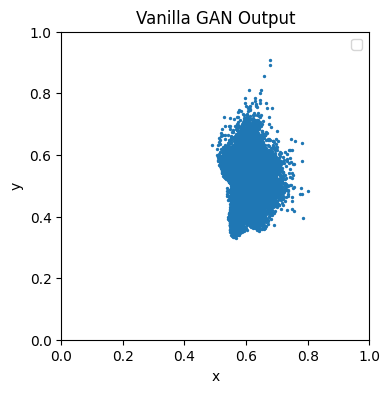

In [15]:
gen_output = net_G(0.5+torch.randn((50000, noise_size))*2)

x_test = gen_output[:, 0].detach().numpy()
y_test = gen_output[:, 1].detach().numpy()


# Plot test data
def plot_xy(x_pts, y_pts):
    plt.figure(figsize=(4, 4))
    plt.scatter(x_test, y_test, alpha=1, s=2)
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title("Vanilla GAN Output")
    plt.gca().set_aspect('equal', adjustable='box')  # Make the plot square
    plt.legend()
    plt.show()

plot_xy(x_test, y_test)